In [1]:
import os
import sys
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import tensorflow as tf
from nltk.tokenize import word_tokenize

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "data"))
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "utils"))
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models"))
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models", "evaluations"))

In [3]:
from DataLoader import DataLoader
from EvaluationContainer import EvaluationContainer

In [4]:
results_folder = "model_recommendations"
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)

# Load test data

In [5]:
d = DataLoader()
d_authors = DataLoader()

In [6]:
query_test, truth = d.evaluation_data_with_abstracts_citations()
query_test_authors = d_authors.test_data_with_abstracts_citations().author_names().data[["author_name", "chapter"]]

Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'chapters_year' not in memory yet.
Process 'books_conferences' not in memory yet.
Process 'conferences_acronym' not in memory yet.
Process 'conferences_city' not in memory yet.
Process 'conferences_country' not in memory yet.
Process 'conferences_datestart' not in memory yet.
Process 'conferences_dateend' not in memory yet.
Process 'conferences_name' not in memory yet.
Process 'conferences_year' not in memory yet.
Process 'conferences_conferenceseries' not in memory yet.
Process 'conferenceseries_name' not in memory yet.
Process 'chapters_abstract' not in memory yet.
Process 'chapters_confproc_scigraph_citations' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'chapters_year' not in memory yet.
Process 'books_conferences' not in memo

### Sample test data (100 random samples)

In [7]:
sample_size = 100

In [8]:
sampled_indices = random.sample(range(len(query_test)), sample_size)

In [9]:
sampled_queries = [query_test[i] for i in sampled_indices]
sampled_truth = [truth[0][i] for i in sampled_indices]

In [10]:
sampled_chapters = [sampled_queries[i][0] for i in range(len(sampled_queries))]

In [11]:
sampled_authors = query_test_authors[query_test_authors.chapter.isin(sampled_chapters)]

In [5]:
sampled_data_file = os.path.join(results_folder, "sampled_data")

In [13]:
with open(sampled_data_file, "wb") as f:
    pickle.dump([sampled_indices, sampled_queries, sampled_truth, sampled_authors], f)

In [6]:
with open(sampled_data_file, "rb") as f:
    sampled_indices, sampled_queries, sampled_truth, sampled_authors = pickle.load(f)

In [7]:
sampled_queries

[('sg:pub.10.1007/978-3-662-54110-4_24',
  'Bounds for the Convergence Time of Local Search in Scheduling Problems',
  'We study the convergence time of local search for a standard machine scheduling problem in which jobs are assigned to identical or related machines. Local search corresponds to the best response dynamics that arises when jobs selfishly try to minimize their costs. We assume that each machine runs a coordination mechanism that determines the order of execution of jobs assigned to it. We obtain various new polynomial and pseudo-polynomial bounds for the well-studied coordination mechanisms Makespan and Shortest-Job-First, using worst-case and smoothed analysis. We also introduce a natural coordination mechanism FIFO, which takes into account the order in which jobs arrive at a machine, and study both its impact on the convergence time and its price of anarchy.',
  ['sg:pub.10.1007/978-3-540-27836-8_31',
   'sg:pub.10.1007/978-3-540-27836-8_31',
   'sg:pub.10.1007/3-540-

# Compute, evaluate and save predictions

In [8]:
evaluator = EvaluationContainer()

### GraphSAGE_RL (supervised, citations)

In [16]:
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models", "graphsage_rl"))
from GraphSAGERLModel import GraphSAGERLModel

In [18]:
graphsagerl_cit_model = GraphSAGERLModel(
                embedding_type="AVG_L",
                graph_type="citations",
                train_prefix="AVG_L/citations/train_val",
                model_name="mean_concat", nonlinear_sampler=True,
                fast_ver=True, allhop_rewards=False, model_size="small",
                learning_rate=0.001, epochs=10, dropout=0.0, weight_decay=0.0,
                max_degree=100, samples_1=25, samples_2=10, samples_3=0,
                dim_1=512, dim_2=512, dim_3=0, batch_size=128, sigmoid=False,
                identity_dim=0,
                base_log_dir='../../../data/processed/graphsage_rl/',
                validate_iter=5000, validate_batch_size=128, gpu=None,
                print_every=5, max_total_steps=10**10,
                log_device_placement=False, recs=10, threshold=2)

INFO:transformers.tokenization_utils:Model name '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' is a path or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file /work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/added_tokens.json. We won't load it.
INFO:transformers.tokenization_

Initializing pretrained SciBERT model.
SciBERT model initialized.
Loading training graph...
Loaded.
Loading training class map...
Loaded.
Loading label encoder.
Loaded.


In [19]:
graphsagerl_cit_recommendations = graphsagerl_cit_model.query_batch((sampled_queries))

Preprocessing data...
Training graph has 144887 nodes and 284069 edges.

Adding test nodes.


Adding edges: 100%|██████████| 100/100 [00:00<00:00, 847.41it/s]


Nodes in graph: 144987.

Adding test edges.
Edges in graph: 284435.

Removing nodes without features.
Nodes in graph: 144987, edges in graph: 284342.

Removed 0 nodes that lacked proper annotations due to networkx versioning issues.
Finished preprocessing data.
Number of nodes in the graph: 144987

Number of edges in the graph: 284342

The graph is connected: False

Number of connected components: 31529

Number of self-loops: 0

Maximum degree: 697

Minimum degree: 0

Average degree: 3.922310276093719

Inference...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Restoring trained model.
Checkpoint file: /work/aiana/graph_confrec/src/models/graphsage_rl/../../../data/processed/graphsage_rl/AVG_L/citations-f512_512_0-s25_10_0-FastML/mean_concat-small-lr0.0010-bs128-ep10/model.ckpt
INFO:tensorflow:Restoring parameters from /work/aiana/graph_confrec/src/models/graphsage_rl/../../../data/processed/graphsage_rl/AVG_L/citations-f512_512_0-s25_10_0-FastML/mean_concat-small-lr0.0010-bs128-ep10/model.ckpt


INFO:tensorflow:Restoring parameters from /work/aiana/graph_confrec/src/models/graphsage_rl/../../../data/processed/graphsage_rl/AVG_L/citations-f512_512_0-s25_10_0-FastML/mean_concat-small-lr0.0010-bs128-ep10/model.ckpt


Model restored.
Computing predictions...
Computed.
Timer :: toc --- 252.5836820602417 seconds ---


In [20]:
len(graphsagerl_cit_recommendations[0])

100

In [11]:
evaluator.evaluate(graphsagerl_cit_recommendations, [sampled_truth])

Recall       = 0.500
Precision(1) = 0.050
Precision(0) = 0.050
MAP          = 0.304
MAP@1        = 0.220
MAP@3        = 0.278
MAP@5        = 0.294
MAP@10       = 0.304
0.5 0.04999999999999998 0.04999999999999998 0.3037460317460317 0.22 0.2783333333333333 0.29433333333333334 0.3037460317460317


[0.5,
 0.04999999999999998,
 0.04999999999999998,
 0.3037460317460317,
 0.22,
 0.2783333333333333,
 0.29433333333333334,
 0.3037460317460317]

In [9]:
graphsagerl_cit_rec_file = os.path.join(results_folder, "graphsagerl_cit_recommendations.pkl")

In [23]:
with open(graphsagerl_cit_rec_file, "wb") as f:
    pickle.dump(graphsagerl_cit_recommendations, f)

In [10]:
with open(graphsagerl_cit_rec_file, "rb") as f:
    graphsagerl_cit_recommendations = pickle.load(f)

### GraphSAGE_RL (supervised, het edges)

In [9]:
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models", "graphsage_rl"))
from GraphSAGERLModel import GraphSAGERLModel

In [10]:
graphsagerl_het_model = GraphSAGERLModel(
                embedding_type="SUM_L",
                graph_type="citations_authors_het_edges",
                train_prefix="SUM_L/citations_authors_het_edges/train_val",
                model_name="mean_concat", nonlinear_sampler=True,
                fast_ver=True, allhop_rewards=True, model_size="small",
                learning_rate=0.001, epochs=10, dropout=0.0, weight_decay=0.0,
                max_degree=100, samples_1=25, samples_2=10, samples_3=0,
                dim_1=512, dim_2=512, dim_3=0, batch_size=128, sigmoid=False,
                identity_dim=0,
                base_log_dir='../../../data/processed/graphsage_rl/',
                validate_iter=5000, validate_batch_size=128, gpu=None,
                print_every=5, max_total_steps=10**10,
                log_device_placement=False, recs=10, threshold=2)

INFO:transformers.file_utils:TensorFlow version 2.0.0 available.
INFO:transformers.file_utils:PyTorch version 1.3.0 available.
INFO:transformers.modeling_xlnet:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:transformers.tokenization_utils:Model name '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' is a path o

Initializing pretrained SciBERT model.
SciBERT model initialized.
Loading training graph...
Loaded.
Loading training class map...
Loaded.
Loading label encoder.
Loaded.


In [11]:
graphsagerl_het_recommendations = graphsagerl_het_model.query_batch((sampled_queries, sampled_authors))

Adding nodes:   0%|          | 0/100 [00:00<?, ?node/s]

Preprocessing data...
Training graph has 144887 nodes and 467527 edges.

Adding test nodes.


Adding edges: 100%|██████████| 100/100 [00:00<00:00, 1976.24it/s]


Nodes in graph: 144987.

Adding test edges.


Adding edges: 100%|██████████| 355/355 [00:00<00:00, 4438.79it/s]

Edges in graph: 467893.



Edges in graph: 467894.

Edges in graph: 467893.

Removing nodes without features.
Nodes in graph: 144987, edges in graph: 467800.

Removed 0 nodes that lacked proper annotations due to networkx versioning issues.
Finished preprocessing data.
Number of nodes in the graph: 144987

Number of edges in the graph: 467800

The graph is connected: False

Number of connected components: 20143

Number of self-loops: 0

Maximum degree: 697

Minimum degree: 0

Average degree: 6.452992337244029

Inference...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Use keras.layers.Dense instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Restoring trained model.
Checkpoint file: /work/aiana/graph_confrec/src/models/graphsage_rl/../../../data/processed/graphsage_rl/SUM_L/citations_authors_het_edges-f512_512_0-s25_10_0-FastML/mean_concat-small-lr0.0010-bs128-ep10/model.ckpt
INFO:tensorflow:Restoring parameters from /work/aiana/graph_confrec/src/models/graphsage_rl/../../../data/processed/graphsage_rl/SUM_L/citations_authors_het_edges-f512_512_0-s25_10_0-FastML/mean_concat-small-lr0.0010-bs128-ep10/model.ckpt


INFO:tensorflow:Restoring parameters from /work/aiana/graph_confrec/src/models/graphsage_rl/../../../data/processed/graphsage_rl/SUM_L/citations_authors_het_edges-f512_512_0-s25_10_0-FastML/mean_concat-small-lr0.0010-bs128-ep10/model.ckpt


Model restored.
Computing predictions...
Computed.
Timer :: toc --- 231.74800395965576 seconds ---


In [12]:
len(graphsagerl_het_recommendations[0])

100

In [14]:
evaluator.evaluate(graphsagerl_het_recommendations, [sampled_truth])

Recall       = 0.520
Precision(1) = 0.052
Precision(0) = 0.052
MAP          = 0.333
MAP@1        = 0.260
MAP@3        = 0.312
MAP@5        = 0.320
MAP@10       = 0.333
0.52 0.05199999999999998 0.05199999999999998 0.33305158730158724 0.26 0.31166666666666665 0.3201666666666666 0.33305158730158724


[0.52,
 0.05199999999999998,
 0.05199999999999998,
 0.33305158730158724,
 0.26,
 0.31166666666666665,
 0.3201666666666666,
 0.33305158730158724]

In [12]:
graphsagerl_het_rec_file = os.path.join(results_folder, "graphsagerl_het_recommendations.pkl")

In [15]:
with open(graphsagerl_het_rec_file, "wb") as f:
    pickle.dump(graphsagerl_het_recommendations, f)

In [13]:
with open(graphsagerl_het_rec_file, "rb") as f:
    graphsagerl_het_recommendations = pickle.load(f)

### GAT (citations)

In [15]:
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models", "gat"))
from GATModel import GATModel

In [16]:
gat_cit_model = GATModel(
                embedding_type="AVG_L", dataset="citations",
                graph_type="directed", hid_units=[64], n_heads=[8, 1],
                learning_rate=0.005, weight_decay=0, epochs=100000,
                batch_size=1, patience=100, residual=True,
                nonlinearity=tf.nn.elu, sparse=True, ffd_drop=0.5,
                attn_drop=0.5, gpu=0, recs=10, threshold=2)

INFO:transformers.file_utils:TensorFlow version 2.0.0 available.
INFO:transformers.file_utils:PyTorch version 1.3.0 available.


Initiating, using gpu None.

Model: SpGAT
Dataset: citations, Embedding: AVG_L
----- Opt. hyperparameters -----
	Learning rate: 0.005
	Weight decay: 0
----- Archi. hyperparameters -----
	Number of layers: 1
	Number of units per layer: [64]
	Number of attention heads: [8, 1]
	Residual: True
	Nonlinearity: <function elu at 0x7fd5d07d3d08>



INFO:transformers.modeling_xlnet:Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .
INFO:transformers.tokenization_utils:Model name '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' is a path or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file /work/aiana/graph_confre

Initializing pretrained SciBERT model.
SciBERT model initialized.
Loading training data.
Loaded.
Loading label encoder.
Loaded.


In [17]:
gat_cit_recommendations = gat_cit_model.query_batch((sampled_queries))

Preprocessing data...
Process 'chapters_year' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'books_conferences' not in memory yet.
Process 'conferences_acronym' not in memory yet.
Process 'conferences_city' not in memory yet.
Process 'conferences_country' not in memory yet.
Process 'conferences_datestart' not in memory yet.
Process 'conferences_dateend' not in memory yet.
Process 'conferences_name' not in memory yet.
Process 'conferences_year' not in memory yet.
Process 'conferences_conferenceseries' not in memory yet.
Process 'conferenceseries_name' not in memory yet.
Process 'chapters_abstract' not in memory yet.
Process 'chapters_confproc_scigraph_citations' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'chapters_year' not in memory yet.
Process 'books_co

Adding neighbours:   1%|          | 1/100 [00:00<00:11,  8.77it/s]

Updating graph information...


Creating features:   0%|          | 0/100 [00:00<?, ?it/s]

Updated.
Creating features for test data...


Creating features: 100%|██████████| 100/100 [03:50<00:00,  1.24s/it]


Created.
Finished preprocessing data.
Adjacency matrix shape: (144987, 144987).
Features matrix shape: (144987, 1536).
Graph size: 144987.
Parameters: batch size=1, nb_nodes=144987, ft_size=1536, nb_classes=1171
Loading model weights...
Loaded.
Computing predictions...

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Computed.


In [18]:
len(gat_cit_recommendations[0])

100

In [19]:
evaluator.evaluate(gat_cit_recommendations, [sampled_truth])

Recall       = 0.640
Precision(1) = 0.064
Precision(0) = 0.064
MAP          = 0.357
MAP@1        = 0.260
MAP@3        = 0.315
MAP@5        = 0.333
MAP@10       = 0.357
0.64 0.06399999999999993 0.06399999999999993 0.35650396825396835 0.26 0.31499999999999995 0.33349999999999996 0.35650396825396835


[0.64,
 0.06399999999999993,
 0.06399999999999993,
 0.35650396825396835,
 0.26,
 0.31499999999999995,
 0.33349999999999996,
 0.35650396825396835]

In [21]:
gat_cit_rec_file = os.path.join(results_folder, "gat_cit_recommendations.pkl")

In [22]:
with open(gat_cit_rec_file, "wb") as f:
    pickle.dump(gat_cit_recommendations, f)

In [ ]:
with open(gat_cit_rec_file, "rb") as f:
    gat_cit_recommendations = pickle.load(f)

### GAT (het edges)

In [23]:
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models", "gat"))
from GATModel import GATModel

In [24]:
gat_het_model = GATModel(
                embedding_type="SUM_2L", dataset="citations_authors_het_edges",
                graph_type="directed", hid_units=[64], n_heads=[8, 1],
                learning_rate=0.005, weight_decay=0, epochs=100000,
                batch_size=1, patience=100, residual=True,
                nonlinearity=tf.nn.elu, sparse=True, ffd_drop=0.5,
                attn_drop=0.5, gpu=0, recs=10, threshold=2)

INFO:transformers.tokenization_utils:Model name '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' is a path or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file /work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/added_tokens.json. We won't load it.
INFO:transformers.tokenization_

Initiating, using gpu None.

Model: SpGAT
Dataset: citations_authors_het_edges, Embedding: SUM_2L
----- Opt. hyperparameters -----
	Learning rate: 0.005
	Weight decay: 0
----- Archi. hyperparameters -----
	Number of layers: 1
	Number of units per layer: [64]
	Number of attention heads: [8, 1]
	Residual: True
	Nonlinearity: <function elu at 0x7fd5d07d3d08>

Initializing pretrained SciBERT model.


INFO:transformers.modeling_utils:loading weights file /work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/pytorch_model.bin


SciBERT model initialized.
Loading training data.
Loaded.
Loading label encoder.
Loaded.


In [25]:
gat_het_recommendations = gat_het_model.query_batch((sampled_queries, sampled_authors))

Preprocessing data...
Process 'chapters_year' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'books_conferences' not in memory yet.
Process 'conferences_acronym' not in memory yet.
Process 'conferences_city' not in memory yet.
Process 'conferences_country' not in memory yet.
Process 'conferences_datestart' not in memory yet.
Process 'conferences_dateend' not in memory yet.
Process 'conferences_name' not in memory yet.
Process 'conferences_year' not in memory yet.
Process 'conferences_conferenceseries' not in memory yet.
Process 'conferenceseries_name' not in memory yet.
Process 'chapters_abstract' not in memory yet.
Process 'chapters_confproc_scigraph_citations' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'chapters_year' not in memory yet.
Process 'books_co

Adding citation neighbours:   0%|          | 0/100 [00:00<?, ?it/s]

Updating graph information...


Creating features:   0%|          | 0/100 [00:00<?, ?it/s]

Updated.
Creating features for test data...


Creating features: 100%|██████████| 100/100 [04:29<00:00,  2.72s/it]


Created.
Finished preprocessing data.
Adjacency matrix shape: (144987, 144987).
Features matrix shape: (144987, 1536).
Graph size: 144987.
Parameters: batch size=1, nb_nodes=144987, ft_size=1536, nb_classes=1171
Loading model weights...
Loaded.
Computing predictions...

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Computed.


In [26]:
len(gat_het_recommendations[0])

100

In [27]:
evaluator.evaluate(gat_het_recommendations, [sampled_truth])

Recall       = 0.650
Precision(1) = 0.065
Precision(0) = 0.065
MAP          = 0.381
MAP@1        = 0.280
MAP@3        = 0.342
MAP@5        = 0.362
MAP@10       = 0.381
0.65 0.06499999999999993 0.06499999999999993 0.38090079365079377 0.28 0.3416666666666666 0.3621666666666667 0.38090079365079377


[0.65,
 0.06499999999999993,
 0.06499999999999993,
 0.38090079365079377,
 0.28,
 0.3416666666666666,
 0.3621666666666667,
 0.38090079365079377]

In [28]:
gat_het_rec_file = os.path.join(results_folder, "gat_het_recommendations.pkl")

In [29]:
with open(gat_het_rec_file, "wb") as f:
    pickle.dump(gat_het_recommendations, f)

In [ ]:
with open(gat_het_rec_file, "rb") as f:
    gat_het_recommendations = pickle.load(f)

### HAN

In [30]:
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models", "han"))
from HANModel import HANModel

In [31]:
han_model = HANModel(
                model="HeteGAT_multi", embedding_type="AVG_L", hid_units=[128],
                n_heads=[8, 1], learning_rate=0.005, weight_decay=0,
                epochs=10000, batch_size=1, patience=100, residual=True,
                nonlinearity=tf.nn.elu, ffd_drop=0.5, attn_drop=0.5, gpu=0,
                recs=10)

Initiating, using gpu None.



INFO:transformers.tokenization_utils:Model name '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' is a path or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file /work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/added_tokens.json. We won't load it.
INFO:transformers.tokenization_

Model: HeteGAT_multi
Embedding: AVG_L
----- Opt. hyperparameters -----
	Learning rate: 0.005
	Weight decay: 0
----- Archi. hyperparameters -----
	Number of layers: 1
	Number of units per layer: [128]
	Number of attention heads: [8, 1]
	Residual: True
	Nonlinearity: <function elu at 0x7fd5d07d3d08>

Initializing pretrained SciBERT model.
SciBERT model initialized.
Loading training data.
Loaded.
Loading label encoder.
Loaded.


In [32]:
han_recommendations = han_model.query_batch((sampled_queries, sampled_authors))

Preprocessing data...
Process 'chapters_year' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'books_conferences' not in memory yet.
Process 'conferences_acronym' not in memory yet.
Process 'conferences_city' not in memory yet.
Process 'conferences_country' not in memory yet.
Process 'conferences_datestart' not in memory yet.
Process 'conferences_dateend' not in memory yet.
Process 'conferences_name' not in memory yet.
Process 'conferences_year' not in memory yet.
Process 'conferences_conferenceseries' not in memory yet.
Process 'conferenceseries_name' not in memory yet.
Process 'chapters_abstract' not in memory yet.
Process 'chapters_confproc_scigraph_citations' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'chapters_year' not in memory yet.
Process 'books_co

Adding neighbours:   0%|          | 0/100 [00:00<?, ?it/s]

Updating graph information...
Updating paper-citation-paper adjacency lists.


Adding neighbours:   1%|▏         | 5/355 [00:00<00:07, 48.10it/s]

Updated.
Updating paper-author-paper adjacency lists.


Adding neighbours: 100%|██████████| 355/355 [00:06<00:00, 57.10it/s]


Updated.
Updated.


Creating features:   0%|          | 0/100 [00:00<?, ?it/s]

PCP: (144987, 144987); PAP: (144987, 144987)
Creating features for test data...


Creating features: 100%|██████████| 100/100 [03:37<00:00,  2.68s/it]


Features: (144987, 1536)
Created.
Finished preprocessing data.
y_train: (144987, 1171), y_test: (144987, 1171), train_idx: (1, 137376), test_idx: (1, 100)
(144987, 144987)
(144987, 144987)
Parameters: batch size=1, nb_nodes=144987, ft_size=1536, nb_classes=1171
Loading model weights...
Loaded.
Computing predictions...

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



Computed.


In [33]:
len(han_recommendations[0])

100

In [34]:
evaluator.evaluate(han_recommendations, [sampled_truth])

Recall       = 0.610
Precision(1) = 0.061
Precision(0) = 0.061
MAP          = 0.352
MAP@1        = 0.250
MAP@3        = 0.310
MAP@5        = 0.337
MAP@10       = 0.352
0.61 0.06099999999999994 0.06099999999999994 0.3522579365079366 0.25 0.31 0.337 0.3522579365079366


[0.61,
 0.06099999999999994,
 0.06099999999999994,
 0.3522579365079366,
 0.25,
 0.31,
 0.337,
 0.3522579365079366]

In [35]:
han_rec_file = os.path.join(results_folder, "han_recommendations.pkl")

In [36]:
with open(han_rec_file, "wb") as f:
    pickle.dump(han_recommendations, f)

In [ ]:
with open(han_rec_file, "rb") as f:
    han_recommendations = pickle.load(f)

### SciBERT + ARGA (citations)

In [37]:
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models", "scibert_arga"))
from SciBERT_ARGAModel import SciBERT_ARGAModel

In [38]:
scibert_arga_cit_model = SciBERT_ARGAModel(
                embedding_type="AVG_2L", dataset="citations", arga_model_name="ARGVA",
                graph_type="directed", n_latent=16, learning_rate=0.001,
                weight_decay=0, dropout=0, dis_loss_para=1, reg_loss_para=1,
                epochs=200, gpu=None, ffnn_hidden_dim=500, recs=10)

INFO:transformers.tokenization_utils:Model name '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' is a path or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file /work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/added_tokens.json. We won't load it.
INFO:transformers.tokenization_

Initializing pretrained SciBERT model.


INFO:transformers.modeling_utils:loading weights file /work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/pytorch_model.bin
INFO:transformers.tokenization_utils:Model name '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' is a path or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find f

SciBERT model initialized.
Initializing pretrained SciBERT model.


INFO:transformers.modeling_utils:loading weights file /work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/pytorch_model.bin


SciBERT model initialized.
Model: ARGVA
	Embedding: AVG_2L, Dataset: citations, Graph type: directed
	Hidden units: 16
	Learning rate: 0.001
	Weight decay: 0
	Dropout: 0

	Epochs: 200

Loading training data...
Process 'chapters_year' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'books_conferences' not in memory yet.
Process 'conferences_acronym' not in memory yet.
Process 'conferences_city' not in memory yet.
Process 'conferences_country' not in memory yet.
Process 'conferences_datestart' not in memory yet.
Process 'conferences_dateend' not in memory yet.
Process 'conferences_name' not in memory yet.
Process 'conferences_year' not in memory yet.
Process 'conferences_conferenceseries' not in memory yet.
Process 'conferenceseries_name' not in memory yet.
Process 'chapters_abstract' not in memory yet.
Process 'chapters_confproc_scigraph_citations' not in memory yet.
Process

In [39]:
scibert_arga_cit_recommendations = scibert_arga_cit_model.query_batch(sampled_queries)

Process 'chapters_year' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'books_conferences' not in memory yet.
Process 'conferences_acronym' not in memory yet.
Process 'conferences_city' not in memory yet.
Process 'conferences_country' not in memory yet.
Process 'conferences_datestart' not in memory yet.
Process 'conferences_dateend' not in memory yet.
Process 'conferences_name' not in memory yet.
Process 'conferences_year' not in memory yet.
Process 'conferences_conferenceseries' not in memory yet.
Process 'conferenceseries_name' not in memory yet.
Process 'chapters_abstract' not in memory yet.
Process 'chapters_confproc_scigraph_citations' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'chapters_year' not in memory yet.
Process 'books_conferences' not in memo

Adding neighbours:   0%|          | 0/100 [00:00<?, ?it/s]

Preprocessing data...
Updating graph information...


Creating features:   0%|          | 0/100 [00:00<?, ?it/s]

Updated.
Creating features for test data...


Creating features: 100%|██████████| 100/100 [04:46<00:00,  1.63s/it]


Created.
Finished preprocessing data.
Splitting edges...


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

Finished splitting edges.
Loading model...
Loaded.

Computing embeddings...


Computing SciBERT embeddings:   0%|          | 0/100 [00:00<?, ?it/s]

Computed.



Computing SciBERT embeddings: 100%|██████████| 100/100 [03:07<00:00,  2.21s/it]


Computed.
Loading model...
Loaded.

Computing predictions...
Computed.


In [40]:
len(scibert_arga_cit_recommendations[0])

100

In [41]:
evaluator.evaluate(scibert_arga_cit_recommendations, [sampled_truth])

Recall       = 0.580
Precision(1) = 0.058
Precision(0) = 0.058
MAP          = 0.319
MAP@1        = 0.220
MAP@3        = 0.280
MAP@5        = 0.296
MAP@10       = 0.319
0.58 0.057999999999999954 0.057999999999999954 0.3194246031746032 0.22 0.27999999999999997 0.29649999999999993 0.3194246031746032


[0.58,
 0.057999999999999954,
 0.057999999999999954,
 0.3194246031746032,
 0.22,
 0.27999999999999997,
 0.29649999999999993,
 0.3194246031746032]

In [42]:
scibert_arga_cit_rec_file = os.path.join(results_folder, "scibert_arga_cit_recommendations.pkl")

In [43]:
with open(scibert_arga_cit_rec_file, "wb") as f:
    pickle.dump(scibert_arga_cit_recommendations, f)

In [ ]:
with open(scibert_arga_cit_rec_file, "rb") as f:
    scibert_arga_cit_recommendations = pickle.load(f)

### SciBERT + ARGA (het edges)

In [44]:
sys.path.insert(0, os.path.join(os.getcwd(), "..", "src", "models", "scibert_arga"))
from SciBERT_ARGAModel import SciBERT_ARGAModel

In [45]:
scibert_arga_het_model = SciBERT_ARGAModel(
                embedding_type="AVG_L", dataset="citations_authors_het_edges", arga_model_name="ARGA",
                graph_type="directed", n_latent=16, learning_rate=0.001,
                weight_decay=0, dropout=0, dis_loss_para=1, reg_loss_para=1,
                epochs=200, gpu=None, ffnn_hidden_dim=500, recs=10)

INFO:transformers.tokenization_utils:Model name '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' is a path or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file /work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/added_tokens.json. We won't load it.
INFO:transformers.tokenization_

Initializing pretrained SciBERT model.


INFO:transformers.tokenization_utils:Model name '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased). Assuming '/work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/vocab.txt' is a path or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:Didn't find file /work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/added_tokens.json. We won't load it.
INFO:transformers.tokenization_

SciBERT model initialized.
Initializing pretrained SciBERT model.


INFO:transformers.modeling_utils:loading weights file /work/aiana/graph_confrec/src/data/../../data/external/scibert_scivocab_uncased/pytorch_model.bin


SciBERT model initialized.
Model: ARGA
	Embedding: AVG_L, Dataset: citations_authors_het_edges, Graph type: directed
	Hidden units: 16
	Learning rate: 0.001
	Weight decay: 0
	Dropout: 0

	Epochs: 200

Loading training data...
Process 'chapters_year' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'books_conferences' not in memory yet.
Process 'conferences_acronym' not in memory yet.
Process 'conferences_city' not in memory yet.
Process 'conferences_country' not in memory yet.
Process 'conferences_datestart' not in memory yet.
Process 'conferences_dateend' not in memory yet.
Process 'conferences_name' not in memory yet.
Process 'conferences_year' not in memory yet.
Process 'conferences_conferenceseries' not in memory yet.
Process 'conferenceseries_name' not in memory yet.
Process 'chapters_abstract' not in memory yet.
Process 'chapters_confproc_scigraph_citations' not in mem

In [46]:
scibert_arga_het_recommendations = scibert_arga_het_model.query_batch((sampled_queries, sampled_authors))

Process 'chapters_year' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'books_conferences' not in memory yet.
Process 'conferences_acronym' not in memory yet.
Process 'conferences_city' not in memory yet.
Process 'conferences_country' not in memory yet.
Process 'conferences_datestart' not in memory yet.
Process 'conferences_dateend' not in memory yet.
Process 'conferences_name' not in memory yet.
Process 'conferences_year' not in memory yet.
Process 'conferences_conferenceseries' not in memory yet.
Process 'conferenceseries_name' not in memory yet.
Process 'chapters_abstract' not in memory yet.
Process 'chapters_confproc_scigraph_citations' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'chapters_year' not in memory yet.
Process 'books_conferences' not in memo

Adding citation neighbours:   0%|          | 0/100 [00:00<?, ?it/s]

Preprocessing data...
Updating graph information...


Creating features:   0%|          | 0/100 [00:00<?, ?it/s]

Updated.
Creating features for test data...


Creating features: 100%|██████████| 100/100 [04:19<00:00,  3.45s/it]


Created.
Finished preprocessing data.
Splitting edges...


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

Finished splitting edges.
Loading model...
Loaded.

Computing embeddings...


Computing SciBERT embeddings:   0%|          | 0/100 [00:00<?, ?it/s]

Computed.



Computing SciBERT embeddings: 100%|██████████| 100/100 [02:40<00:00,  1.35s/it]


Computed.
Loading model...
Loaded.

Computing predictions...
Computed.


In [47]:
len(scibert_arga_het_recommendations[0])

100

In [48]:
evaluator.evaluate(scibert_arga_het_recommendations, [sampled_truth])

Recall       = 0.600
Precision(1) = 0.060
Precision(0) = 0.060
MAP          = 0.338
MAP@1        = 0.230
MAP@3        = 0.303
MAP@5        = 0.317
MAP@10       = 0.338
0.6 0.05999999999999995 0.05999999999999995 0.3384206349206349 0.23 0.3033333333333333 0.3173333333333333 0.3384206349206349


[0.6,
 0.05999999999999995,
 0.05999999999999995,
 0.3384206349206349,
 0.23,
 0.3033333333333333,
 0.3173333333333333,
 0.3384206349206349]

In [49]:
scibert_arga_het_rec_file = os.path.join(results_folder, "scibert_arga_het_recommendations.pkl")

In [50]:
with open(scibert_arga_het_rec_file, "wb") as f:
    pickle.dump(scibert_arga_het_recommendations, f)

In [ ]:
with open(scibert_arga_het_rec_file, "rb") as f:
    scibert_arga_het_recommendations = pickle.load(f)

# Process recommendations

In [51]:
d = DataLoader()
data = d.training_data_with_abstracts_citations().data

Process 'chapters_year' not in memory yet.
Process 'chapters_books' not in memory yet.
Process 'chapters_title' not in memory yet.
Process 'chapters_language' not in memory yet.
Process 'books_conferences' not in memory yet.
Process 'conferences_acronym' not in memory yet.
Process 'conferences_city' not in memory yet.
Process 'conferences_country' not in memory yet.
Process 'conferences_datestart' not in memory yet.
Process 'conferences_dateend' not in memory yet.
Process 'conferences_name' not in memory yet.
Process 'conferences_year' not in memory yet.
Process 'conferences_conferenceseries' not in memory yet.
Process 'conferenceseries_name' not in memory yet.
Process 'chapters_abstract' not in memory yet.
Process 'chapters_confproc_scigraph_citations' not in memory yet.


In [52]:
def get_series_name(data, recommendation):
    conferenceseries = list()
    for conf in recommendation:
        conferenceseries.append(
                data[data.conferenceseries == conf].iloc[0]["conferenceseries_name"])
    return conferenceseries

In [53]:
graphsagerl_cit_conferences = list()
for i in range(len(graphsagerl_cit_recommendations[0])):
    rec = graphsagerl_cit_recommendations[0][i]
    graphsagerl_cit_conferences.extend(get_series_name(data, rec))
len(graphsagerl_cit_conferences)

1000

In [54]:
graphsagerl_het_conferences = list()
for i in range(len(graphsagerl_het_recommendations[0])):
    rec = graphsagerl_het_recommendations[0][i]
    graphsagerl_het_conferences.extend(get_series_name(data, rec))
len(graphsagerl_het_conferences)

1000

In [55]:
gat_cit_conferences = list()
for i in range(len(gat_cit_recommendations[0])):
    rec = gat_cit_recommendations[0][i]
    gat_cit_conferences.extend(get_series_name(data, rec))
len(gat_cit_conferences)

1000

In [56]:
gat_het_conferences = list()
for i in range(len(gat_het_recommendations[0])):
    rec = gat_het_recommendations[0][i]
    gat_het_conferences.extend(get_series_name(data, rec))
len(gat_het_conferences)

1000

In [57]:
han_conferences = list()
for i in range(len(han_recommendations[0])):
    rec = han_recommendations[0][i]
    han_conferences.extend(get_series_name(data, rec))
len(han_conferences)

1000

In [58]:
scibert_arga_cit_conferences = list()
for i in range(len(scibert_arga_cit_recommendations[0])):
    rec = scibert_arga_cit_recommendations[0][i]
    scibert_arga_cit_conferences.extend(get_series_name(data, rec))
len(scibert_arga_cit_conferences)

1000

In [59]:
scibert_arga_het_conferences = list()
for i in range(len(scibert_arga_het_recommendations[0])):
    rec = scibert_arga_het_recommendations[0][i]
    scibert_arga_het_conferences.extend(get_series_name(data, rec))
len(scibert_arga_het_conferences)

1000

# Compute similarities

In [60]:
def jaccard_similarity(list1, list2): 
    tokenized_list1 = list()
    tokenized_list2 = list()
    for string in list1:
        tokenized_list1.extend(word_tokenize(string))
    for string in list2:
        tokenized_list2.extend(word_tokenize(string))
    set1 = set(tokenized_list1) 
    set2 = set(tokenized_list2)
    return len(set1.intersection(set2)) / len(set1.union(set2))

In [62]:
recommendations = {"graphsagerl (citations graph)": graphsagerl_cit_conferences, 
                   "graphsagerl (heterogenous graph)": graphsagerl_het_conferences, 
                   "gat (citations graph)": gat_cit_conferences,
                   "gat (heterogenous graph)": gat_het_conferences,
                   "han": han_conferences, 
                   "scibert_arga (citations graph)": scibert_arga_cit_conferences,
                   "scibert_arga (heterogenous graph)": scibert_arga_het_conferences}

In [63]:
sim_df = pd.DataFrame(np.ones((len(recommendations.keys()), len(recommendations.keys()))), 
                      index=list(recommendations.keys()), columns=list(recommendations.keys()))
sim_df

,graphsagerl (citations graph),graphsagerl (heterogenous graph),gat (citations graph),gat (heterogenous graph),han,scibert_arga (citations graph),scibert_arga (heterogenous graph)
graphsagerl (citations graph),1.0,1.0,1.0,1.0,1.0,1.0,1.0
graphsagerl (heterogenous graph),1.0,1.0,1.0,1.0,1.0,1.0,1.0
gat (citations graph),1.0,1.0,1.0,1.0,1.0,1.0,1.0
gat (heterogenous graph),1.0,1.0,1.0,1.0,1.0,1.0,1.0
han,1.0,1.0,1.0,1.0,1.0,1.0,1.0
scibert_arga (citations graph),1.0,1.0,1.0,1.0,1.0,1.0,1.0
scibert_arga (heterogenous graph),1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [64]:
for models in itertools.combinations(recommendations.keys(), 2):
    sim_df.loc[models] = sim_df.loc[tuple(reversed(models))] = jaccard_similarity(recommendations[models[0]],
                                                                                 recommendations[models[1]])

In [65]:
sim_df

,graphsagerl (citations graph),graphsagerl (heterogenous graph),gat (citations graph),gat (heterogenous graph),han,scibert_arga (citations graph),scibert_arga (heterogenous graph)
graphsagerl (citations graph),1.000000,0.776650,0.762852,0.771757,0.710485,0.733871,0.756579
graphsagerl (heterogenous graph),0.776650,1.000000,0.746365,0.749601,0.696183,0.743222,0.737600
gat (citations graph),0.762852,0.746365,1.000000,0.862416,0.830619,0.789644,0.819536
gat (heterogenous graph),0.771757,0.749601,0.862416,1.000000,0.786834,0.800963,0.801292
han,0.710485,0.696183,0.830619,0.786834,1.000000,0.750385,0.777953
scibert_arga (citations graph),0.733871,0.743222,0.789644,0.800963,0.750385,1.000000,0.864094
scibert_arga (heterogenous graph),0.756579,0.737600,0.819536,0.801292,0.777953,0.864094,1.000000


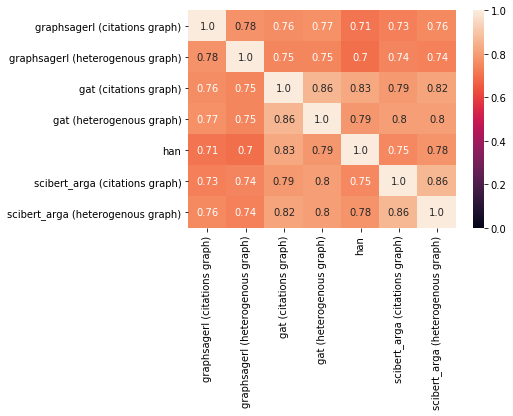

In [67]:
sns.heatmap(sim_df, annot=True, vmin=0, vmax=1, fmt=".2")